In [25]:
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import joblib
import lightgbm as lgb
from matplotlib import pyplot as plt
from sklearn.metrics import plot_roc_curve

In [3]:
model_results = {}
tprs = []
fprs = []
idrs = []
aucs = []
model_names = ["Decision Tree", "Naive Bayes", "Random Forest", "XGBoost", "LightGBM"]
models = []

In [4]:
def add_to_lists(x):
    tprs.append(x[0])
    fprs.append(x[1])
    idrs.append(x[2])
    aucs.append(x[3])

In [5]:
def performance_measure(y_actual, y_predicted):
    TP, FP, TN, FN = 0, 0, 0, 0
    for i in range(len(y_actual)):
        if y_actual[i] != 0 and y_predicted[i] != 0:
            TP += 1
        if y_actual[i] != 0 and y_predicted[i] == 0:
            FN += 1
        if y_actual[i] == 0 and y_predicted[i] == 0:
            TN += 1
        if y_actual[i] == 0 and y_predicted[i] != 0:
            FP += 1
    results = dict({"True Positive":TP, "False Positive":FP, "True Negative":TN, "False Negative":FN})
    return results

In [6]:
def confusion_matrix(conf_matrx_values):
    confusion_matrix = [[0 for i in range(2)] for j in range(2)]
    confusion_matrix[0][0] = conf_matrx_values["True Positive"]
    confusion_matrix[0][1] = conf_matrx_values["False Positive"]
    confusion_matrix[1][0] = conf_matrx_values["False Negative"]
    confusion_matrix[1][1] = conf_matrx_values["True Negative"]
    confusion_matrix = np.asarray(confusion_matrix)
    grp_names = ["True Pos", "False Pos", "False Neg", "True Neg"]
    grp_perc = ["{0:.2%}".format(value) for value in confusion_matrix.flatten()/np.sum(confusion_matrix)]
    labels = [f"{v1}\n{v2}" for v1,v2 in zip(grp_names, grp_perc)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(confusion_matrix/np.sum(confusion_matrix),annot=labels, fmt='', cmap='Reds')


In [7]:
def cal_values(results, y_test, model_output):
    TP = results["True Positive"]
    FP = results["False Positive"]    
    TN = results["True Negative"]
    FN = results["False Negative"]

    TPR = TP / (TP + FN)
    print("The TPR is : %.4f" %TPR)

    FPR = FP/(FP+TN)
    print("The FPR is : %.4f" %FPR)

    IDR = TPR * (1-FPR)
    print("The IDR is : %.4f" %IDR)

    AUC = (roc_auc_score(y_test, model_output))
    print("The AUC value is : %.4f" %AUC)

    return [TPR,FPR,IDR,AUC]

In [8]:
import pandas as pd

In [9]:
df_train = pd.read_csv("./dataset/train.csv", header=None)
df_test = pd.read_csv("./dataset/test.csv", header=None)

In [10]:
df_train = df_train.values
df_test = df_test.values

In [11]:
x_train = df_train[:,:-1]
y_train = df_train[:,-1]

In [12]:
x_test = df_test[:,:-1]
y_test = df_test[:,-1:]

# DECISION TREE

The TPR is : 0.9527
The FPR is : 0.0006
The IDR is : 0.9521
The AUC value is : 0.9760


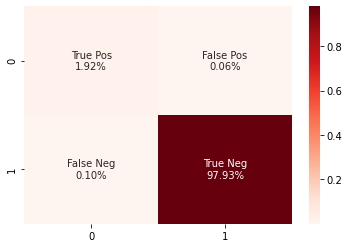

In [13]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
dtc_model_output = dtc.predict(x_test)
models.append(dtc)

dtc_results = performance_measure(y_actual=y_test, y_predicted=dtc_model_output)
confusion_matrix(dtc_results)
model_results["Decision Tree"] = dtc_results

dtc_metrics = cal_values(dtc_results,y_test=y_test,model_output=dtc_model_output)
add_to_lists(dtc_metrics)

## HYPERPARAMTER TUNING

In [14]:
dtc_parameters = {
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10, 50], 
              'min_samples_split': [2, 3, 50, 100],
              'min_samples_leaf': [1, 5, 8, 10]
            }

In [15]:
DTC_grid = GridSearchCV(dtc, param_grid=dtc_parameters, cv=3, verbose=True, n_jobs=-1)

In [16]:
DTC_grid_model = DTC_grid.fit(x_train, y_train)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    7.8s finished


The TPR is : 0.9467
The FPR is : 0.0013
The IDR is : 0.9455
The AUC value is : 0.9727


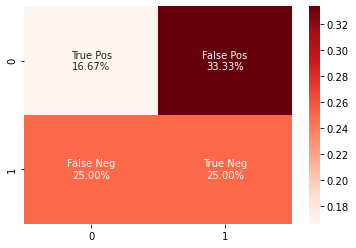

In [180]:
dtc_best = DTC_grid_model.best_estimator_
dtc_best.fit(x_train, y_train)
dtc_best_model_output = dtc_best.predict(x_test)

dtc_best_model_results = performance_measure(y_actual=y_test, y_predicted=dtc_best_model_output)
confusion_matrix(results)

TPR,FPR, IDR, AUC = cal_values(dtc_best_model_results,y_test=y_test,model_output=dtc_best_model_output)

# NAIVE BAYES

The TPR is : 0.6509
The FPR is : 0.0000
The IDR is : 0.6509
The AUC value is : 0.8254


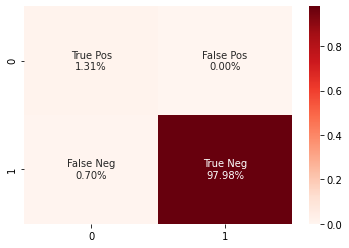

In [17]:
from sklearn.naive_bayes import BernoulliNB
nb = BernoulliNB()
nb.fit(x_train, y_train)
nb_model_output = nb.predict(x_test)
models.append(nb)

nb_results = performance_measure(y_actual=y_test, y_predicted=nb_model_output)
model_results["Naive Bayes"] = nb_results
confusion_matrix(nb_results)

nb_metrics = cal_values(nb_results,y_test=y_test,model_output=nb_model_output)
add_to_lists(nb_metrics)

## HYPERPARAMETER TUNING

In [182]:
nb_parameters = {
    'alpha':[0.01, 0.1, 0.5, 1.0, 10.0]
}

In [183]:
NB_grid = GridSearchCV(nb, param_grid=nb_parameters, n_jobs=-1, cv=3, verbose=True)

In [184]:
NB_grid_model = NB_grid.fit(x_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.1s finished


The TPR is : 0.6509
The FPR is : 0.0000
The IDR is : 0.6509
The AUC value is : 0.8254


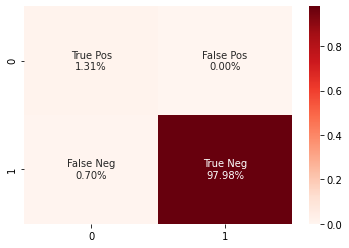

In [185]:
nb_best = NB_grid_model.best_estimator_
nb_best.fit(x_train, y_train)
nb_best_model_output = nb_best.predict(x_test)

nb_best_results = performance_measure(y_actual=y_test, y_predicted=nb_best_model_output)
confusion_matrix(nb_best_results)

TPR,FPR, IDR, AUC = cal_values(nb_best_results,y_test=y_test,model_output=nb_best_model_output)

# RANDOM FOREST

The TPR is : 0.9704
The FPR is : 0.0004
The IDR is : 0.9701
The AUC value is : 0.9850


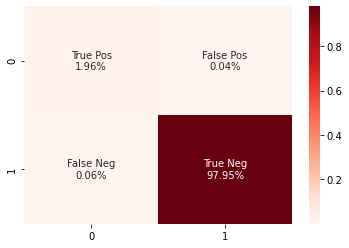

In [18]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
rfc_model_output = rfc.predict(x_test)
models.append(rfc)

rfc_results = performance_measure(y_actual=y_test, y_predicted=rfc_model_output)
confusion_matrix(rfc_results)
model_results["Random Forest"] = rfc_results

rf_metrics = cal_values(rfc_results,y_test=y_test,model_output=rfc_model_output)
add_to_lists(rf_metrics)

## HYPERPARAMETER TUNING

In [187]:
rfc_parameters = {'n_estimators': (10, 30, 50, 70, 90, 100),
              'criterion': ('gini', 'entropy'),
              'max_depth': (3,5,7,9,10),
              'max_features': ('auto','sqrt'),
              'min_samples_split': (2,4,6),
             }

In [188]:
RF_grid = GridSearchCV(rfc, param_grid=rfc_parameters, cv=3, verbose=True, n_jobs=-1)

In [189]:
RF_grid_model = RF_grid.fit(x_train, y_train)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 466 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  2.5min finished


The TPR is : 0.9704
The FPR is : 0.0002
The IDR is : 0.9702
The AUC value is : 0.9851


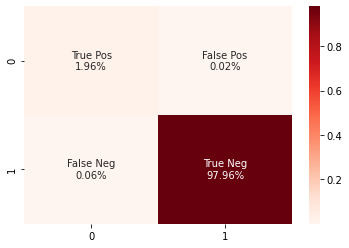

In [190]:
rfc_best = RF_grid_model.best_estimator_
rfc_best.fit(x_train, y_train)
rfc_best_model_output = rfc.predict(x_test)

rfc_best_results = performance_measure(y_actual=y_test, y_predicted=rfc_best_model_output)
confusion_matrix(rfc_best_results)

TPR,FPR, IDR, AUC = cal_values(rfc_best_results,y_test=y_test,model_output=rfc_best_model_output)

# XGBOOST

/home/axebell/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[20:57:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The TPR is : 0.9586
The FPR is : 0.0001
The IDR is : 0.9585
The AUC value is : 0.9792


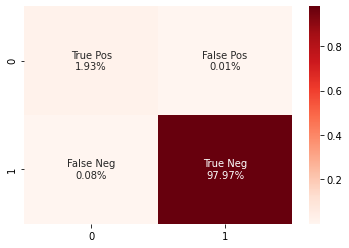

In [19]:
import xgboost as xgb
from xgboost import XGBClassifier
xgm = XGBClassifier()
xgm.fit(x_train, y_train)
xgm_model_output = xgm.predict(x_test)
models.append(xgm)


xgm_results = performance_measure(y_actual=y_test, y_predicted=xgm_model_output)
confusion_matrix(xgm_results)
model_results["xgboost"] = xgm_results

xgm_metrics = cal_values(xgm_results,y_test=y_test,model_output=xgm_model_output)
add_to_lists(xgm_metrics)

# LIGHTGBM

In [20]:
lgb_train = lgb.Dataset(x_train, label=y_train)

In [21]:
    params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 64,
          'learning_rate': 0.07,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 1.2,
          'reg_lambda': 1.2,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'
          }

In [22]:
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 5, 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])

In [23]:
mdl.fit(x_train, y_train)

LGBMClassifier(max_bin=512, min_child_samples=5, min_child_weight=1,
               min_split_gain=0.5, n_jobs=5, objective='binary',
               scale_pos_weight=1, subsample=1, subsample_for_bin=200,
               subsample_freq=1)

The TPR is : 0.9704
The FPR is : 0.0004
The IDR is : 0.9701
The AUC value is : 0.9850


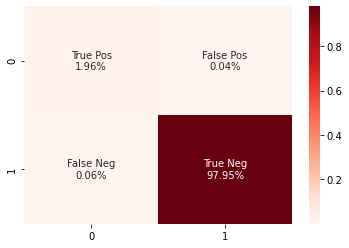

In [24]:
lgm_output = mdl.predict(x_test)
lgm_model_output = mdl.predict(x_test)
models.append(mdl)

lgm_results = performance_measure(y_actual=y_test, y_predicted=lgm_model_output)
confusion_matrix(lgm_results)
model_results["lightgbm"] = lgm_results

lgm_metrics = cal_values(lgm_results,y_test=y_test,model_output=lgm_model_output)
add_to_lists(lgm_metrics)

[0.9467455621301775, 0.650887573964497, 0.9704142011834319, 0.9585798816568047, 0.9704142011834319]


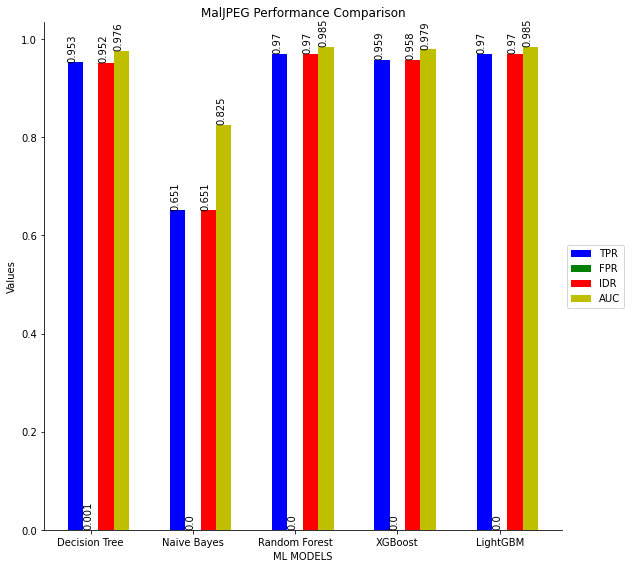

In [41]:
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
index = np.arange(0,5*2,2)
bar_width = 0.3
#opacity = 0.8

metric1 = plt.bar(index, tprs, bar_width, color='b', label='TPR')
metric2 = plt.bar(index+bar_width, fprs, bar_width, color='g', label='FPR')
metric3 = plt.bar(index+2*bar_width, idrs, bar_width, color='r', label='IDR')
metric4 = plt.bar(index+3*bar_width, aucs, bar_width, color='y', label='AUC')

plt.xlabel('ML MODELS')
plt.ylabel('Values')
plt.title('MalJPEG Performance Comparison')
plt.xticks(index+bar_width, model_names)
plt.legend()

for metric in [metric1, metric2, metric3, metric4]:
    for bar in metric:
        yval = round(bar.get_height(), 3)
        plt.text(bar.get_x(), yval+.005, yval,rotation='vertical')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.set_figheight(8)
fig.set_figwidth(8)
plt.tight_layout()
plt.savefig('test.png')


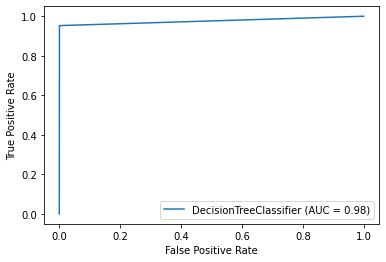

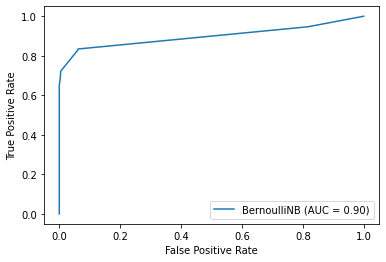

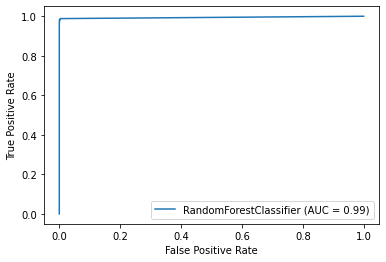

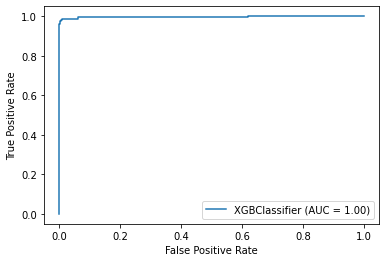

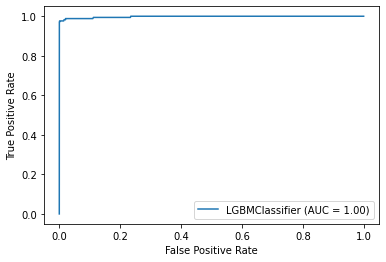

In [43]:
for model in models:
    plot_roc_curve(model,x_test,y_test)

In [ ]:
s